<a href="https://colab.research.google.com/github/saghar-trade/Time-series/blob/main/EWMA%26HoltWinter_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt



In [4]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/air_passengers.csv' , index_col='Month' , parse_dates=True)
df.tail()

Mounted at /content/drive


,Passengers
Month,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


In [5]:
df.isna().sum()

,0
Passengers,0


<Axes: xlabel='Month'>

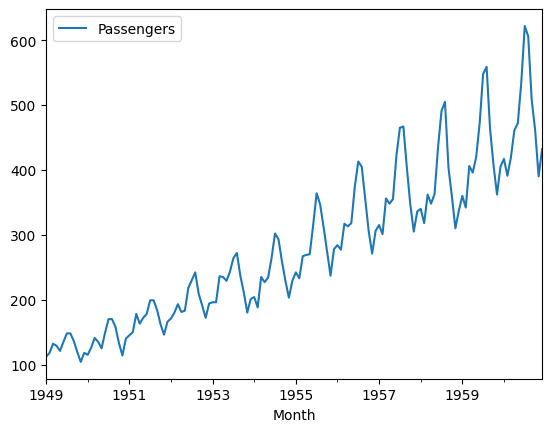

In [6]:
df.plot()

In [7]:
alpha=0.2

In [8]:
df['EWMA']=df['Passengers'].ewm(alpha=alpha,adjust=False).mean()

<Axes: xlabel='Month'>

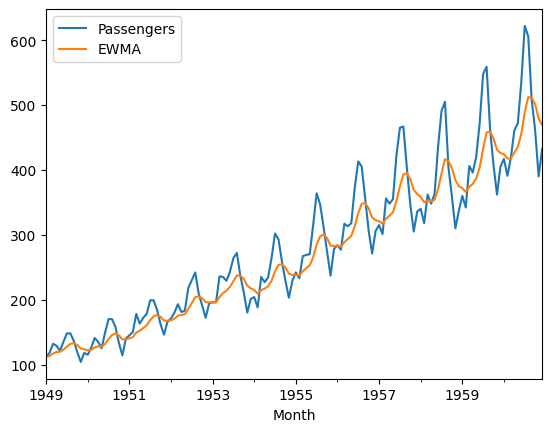

In [9]:
df.plot()

In [10]:
manual_ewma=[]
for x in df['Passengers'].to_numpy():
  if len(manual_ewma)>0:
    xhat=alpha*x+(1-alpha)*manual_ewma[-1]

  else:
    xhat=x
  manual_ewma.append(xhat)
df['Manual']=manual_ewma

<Axes: xlabel='Month'>

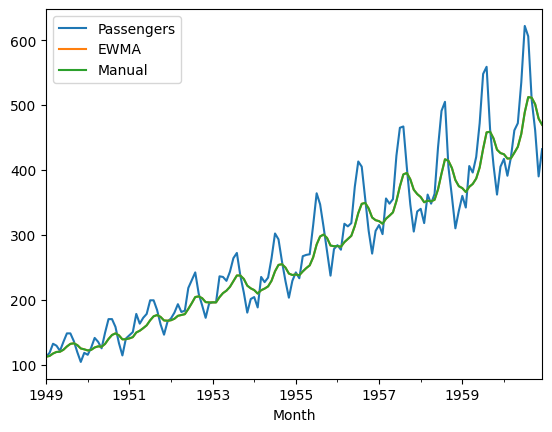

In [11]:
df.plot()

In [12]:
df.head()

,Passengers,EWMA,Manual
Month,,,
1949-01-01,112,112.0000,112.0000
1949-02-01,118,113.2000,113.2000
1949-03-01,132,116.9600,116.9600
1949-04-01,129,119.3680,119.3680
1949-05-01,121,119.6944,119.6944


In [13]:
df.drop('Manual', axis=1,inplace=True)

In [14]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing


In [15]:
!pip install -U statsmodels

In [16]:
ses=SimpleExpSmoothing(df['Passengers'])

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [17]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [18]:
df.index_freq='MS'

In [19]:
ses=SimpleExpSmoothing(
    df['Passengers'], initialization_method='legacy-heuristic'
)

In [20]:
res=ses.fit(smoothing_level=alpha, optimized=False)


In [21]:
res.predict(start=df.index[0], end=df.index[-1])
df['SES']=res.predict(start=df.index[0], end=df.index[-1])
df['SES']

,SES
Month,
1949-01-01,112.000000
1949-02-01,112.000000
1949-03-01,113.200000
1949-04-01,116.960000
1949-05-01,119.368000
...,...
1960-08-01,488.767616
1960-09-01,512.214093
1960-10-01,511.371274


In [22]:
np.allclose(df['SES'], res.fittedvalues)

True

<Axes: xlabel='Month'>

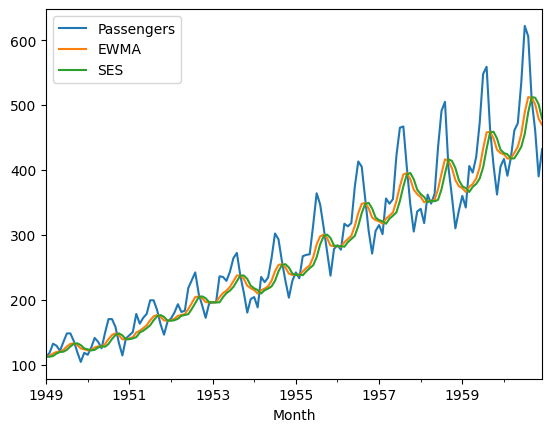

In [23]:
df.plot()

In [24]:
df.head()

,Passengers,EWMA,SES
Month,,,
1949-01-01,112,112.0000,112.000
1949-02-01,118,113.2000,112.000
1949-03-01,132,116.9600,113.200
1949-04-01,129,119.3680,116.960
1949-05-01,121,119.6944,119.368


In [25]:
#this is a wrong way of fitting, not perscripted
df['SES-1']=df['SES'].shift(-1)

<Axes: xlabel='Month'>

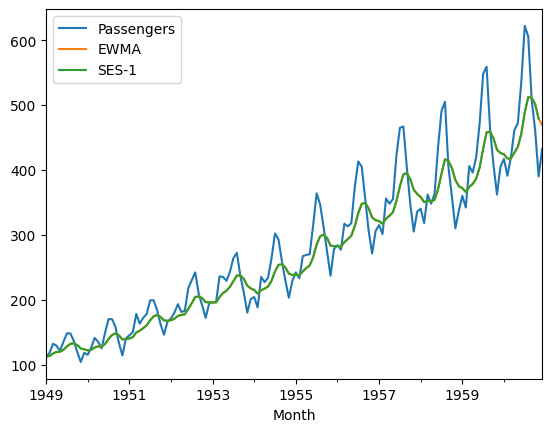

In [26]:
df[['Passengers','EWMA','SES-1']].plot()

In [27]:
no_test=12
train=df.iloc[:-no_test]
test=df.iloc[-no_test:]

In [28]:
train.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1959-03-01', '1959-04-01', '1959-05-01', '1959-06-01',
               '1959-07-01', '1959-08-01', '1959-09-01', '1959-10-01',
               '1959-11-01', '1959-12-01'],
              dtype='datetime64[ns]', name='Month', length=132, freq=None)

In [29]:

ses=SimpleExpSmoothing(
   train['Passengers'], initialization_method='legacy-heuristic'
)
res=ses.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [30]:
train_idx=df.index<=train.index[-1]
test_idx=df.index > train.index[-1]

In [31]:
df.loc[train_idx,'SESfitted']=res.fittedvalues
df.loc[test_idx,'SESfitted']=res.forecast(no_test)



<Axes: xlabel='Month'>

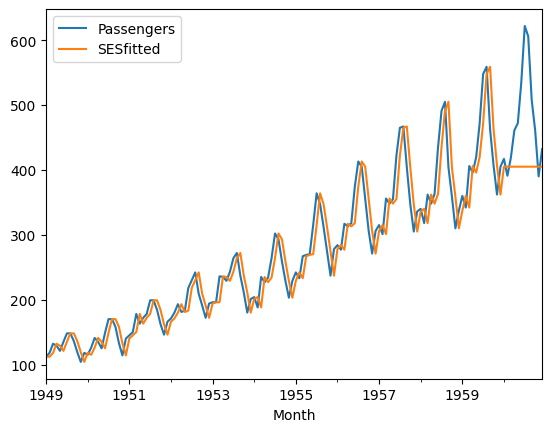

In [32]:
df[['Passengers','SESfitted']].plot()

In [33]:
res.params

{'smoothing_level': np.float64(0.9999999850988388),
 'smoothing_trend': np.float64(nan),
 'smoothing_seasonal': np.float64(nan),
 'damping_trend': nan,
 'initial_level': np.float64(112.0),
 'initial_trend': np.float64(nan),
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [34]:
from statsmodels.tsa.holtwinters import Holt

In [35]:

holt=Holt(
  df['Passengers'], initialization_method='legacy-heuristic'
)
res_h=holt.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [36]:
df['Holt']=res_h.fittedvalues

<Axes: xlabel='Month'>

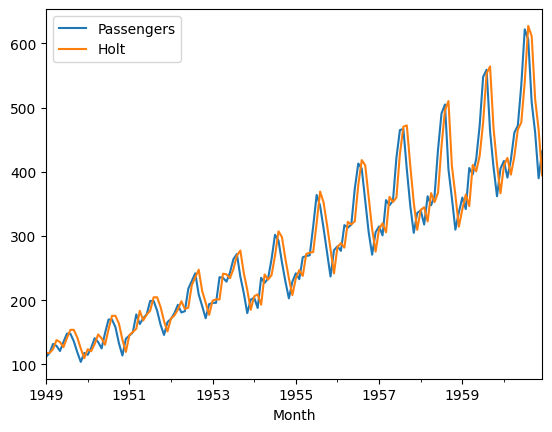

In [37]:
df[['Passengers', 'Holt']].plot()

In [38]:
df['Holt-1']=df['Holt'].shift(-1)


<Axes: xlabel='Month'>

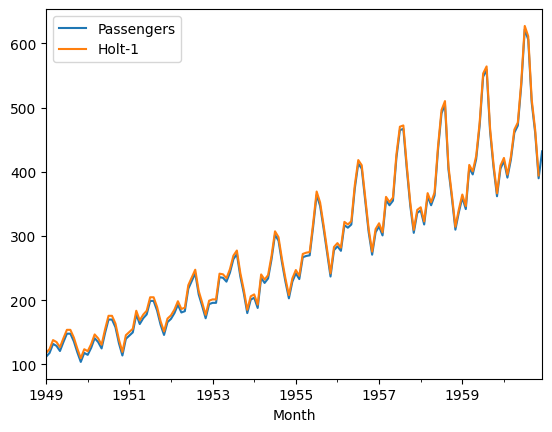

In [39]:
df[['Passengers', 'Holt-1']].plot()

In [40]:
holt=Holt(
  train['Passengers'], initialization_method='legacy-heuristic'
)
res_h=holt.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [41]:
df.loc[train_idx, 'Holt']=res_h.fittedvalues
df.loc[test_idx, 'Holt']=res_h.forecast(no_test)

<Axes: xlabel='Month'>

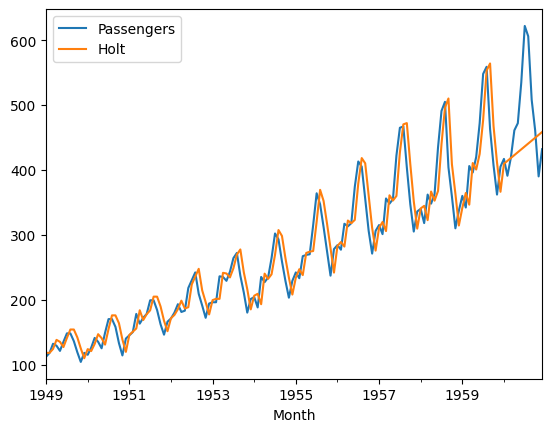

In [42]:
df[['Passengers', 'Holt']].plot()

In [43]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [44]:
hw=ExponentialSmoothing(
  train['Passengers'], initialization_method='legacy-heuristic', trend='add',
  seasonal='add', seasonal_periods=12
)
res_hw=hw.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [45]:
df.loc[train_idx, 'HoltWinter']=res_hw.fittedvalues
df.loc[test_idx, 'HoltWinter']=res_hw.forecast(no_test)

<Axes: xlabel='Month'>

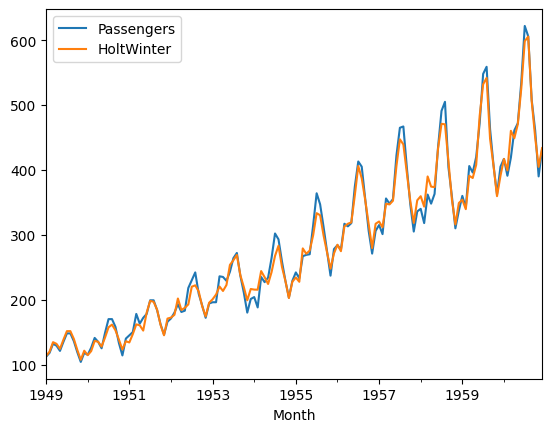

In [46]:
df[['Passengers', 'HoltWinter']].plot()

In [52]:
def rmse(y,t):
  return(np.sqrt(np.mean((y-t)**2)))

In [50]:
def mae(y,t):
  return(np.mean(np.abs(y-t)))

In [53]:
print("Train RMSE:", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hw.forecast(no_test)))

print("Train MAE:", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Passengers'], res_hw.forecast(no_test)))


Train RMSE: 11.85299095492107
Test RMSE: 15.54310494790158
Train MAE: 8.892100161137758
Test MAE: 10.438211267906388


In [55]:
hwm=ExponentialSmoothing(
  train['Passengers'], initialization_method='legacy-heuristic', trend='add',
  seasonal='mul', seasonal_periods=12
)
res_hwm=hwm.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [56]:
df.loc[train_idx, 'HoltWintermul']=res_hwm.fittedvalues
df.loc[test_idx, 'HoltWintermul']=res_hwm.forecast(no_test)

<Axes: xlabel='Month'>

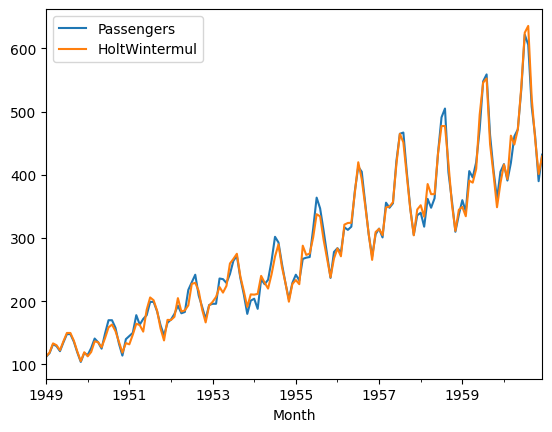

In [57]:
df[['Passengers', 'HoltWintermul']].plot()

In [58]:
print("Train RMSE:", rmse(train['Passengers'], res_hwm.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hwm.forecast(no_test)))

print("Train MAE:", mae(train['Passengers'], res_hwm.fittedvalues))
print("Test MAE:", mae(test['Passengers'], res_hwm.forecast(no_test)))

Train RMSE: 10.153934838981055
Test RMSE: 16.535217423553572
Train MAE: 7.5520521938866265
Test MAE: 10.683343722717524


In [59]:
hwmm=ExponentialSmoothing(
  train['Passengers'], initialization_method='legacy-heuristic', trend='mul',
  seasonal='mul', seasonal_periods=12
)
res_hwmm=hwmm.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [60]:
df.loc[train_idx, 'HoltWintermulmul']=res_hwmm.fittedvalues
df.loc[test_idx, 'HoltWintermulmul']=res_hwmm.forecast(no_test)

<Axes: xlabel='Month'>

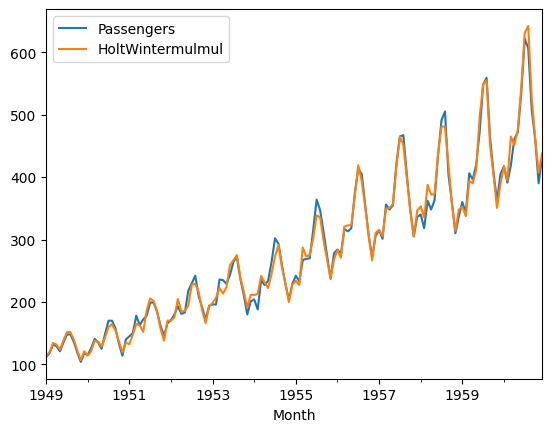

In [61]:
df[['Passengers', 'HoltWintermulmul']].plot()

In [62]:
print("Train RMSE:", rmse(train['Passengers'], res_hwmm.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hwmm.forecast(no_test)))

print("Train MAE:", mae(train['Passengers'], res_hwmm.fittedvalues))
print("Test MAE:", mae(test['Passengers'], res_hwmm.forecast(no_test)))

Train RMSE: 9.887178133763879
Test RMSE: 19.101890824949145
Train MAE: 7.408709641654618
Test MAE: 13.450244770175496
